Ben: A lot of unfamiliar packages here, more on the way. pipenv/virtual environments are your friend. A quick disclaimer that I am barely familiar with this domain of financial modeling, i can be very wrong in my understanding of things. i hope my code is readable.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from pandas_datareader import data as pdr
import pandas_ta as ta #commented out for me for now, I (Ben) had some dependency issues

import yfinance as yf
# import quandl as qd # not used, ignor ples
from backtesting import Backtest, Strategy

In [57]:
yf.pdr_override() # for use with pandas-datareader, optional

# Data Sources/Exploration
## which stocks/tickers will we be looking at?
We've more or less arbitrarily settled on the current S&P 500 index, a popular choice.
## What data do we need, and where can we get it?
We need OHLC (open high low close) data, on a monthly and daily scale. Using yfinance, a module that basically scrapes the ya"hoo finance site for data on tickers, we can get most of what we need.
## 

In [58]:
ticker = pd.read_csv('ticker.csv')['Ticker']
tickers = ticker.to_list() # This is a list of all tickers in the SP500
tickers = [x.replace('.','-') for x in tickers] # yahoo has '-' instead of '.' for tickers, eg BRK.B
ticker.head()

0     AAPL
1     MSFT
2     AMZN
3       FB
4    GOOGL
Name: Ticker, dtype: object

In [59]:
# tickers

In [60]:
# sp_500 = {x:yf.Ticker(x) for x in tickers} # a dict of initialized yfinance tickers
# sp_500['AAPL'].history(start='2019-01-01', end='2020-12-31', interval='1mo')
# sp_500['AAPL'].history(start='2010-01-01', end='2020-12-31')

how to map them to the indicators
we get the prices of each inex but we dont knwo how to get the rest of the data 
aapl 
they put it mext t

In [61]:
# sp500m.to_csv('SP500_monthly.csv') # run/uncomment some of these to save these to csv
# sp500d.to_csv('SP500_daily.csv')
df = pd.read_csv('SP500_monthly.csv').infer_objects().dropna()
# df = sp500m.infer_objects().dropna()#.reset_index() # dataframe of all we basically want, OHLC data w/ adjusted close. didnt set any ind
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
...,...,...,...,...,...,...,...,...
65951,2020-12-01,18.010000,18.730000,17.049999,17.770000,17.770000,1.891130e+07,NWS
65952,2021-01-01,17.959999,19.420000,17.590000,18.879999,18.879999,1.800300e+07,NWS
65953,2021-02-01,18.590000,24.110001,18.299999,22.920000,22.920000,1.325420e+07,NWS
65954,2021-03-01,23.209999,23.870001,22.389999,23.500000,23.500000,2.094900e+06,NWS


In [62]:
st = pd.to_datetime(df.Date.min())
et = pd.to_datetime(df.Date.max())
j=1
k=2
# the 'midpoints' for each observe and hold period. midpoint in this context is where we switch from the observation period len=j to the holding period len=k
j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS")
j_end.strftime("%Y-%m-%d").to_list()[:10]

['2010-05-01',
 '2010-11-01',
 '2011-05-01',
 '2011-11-01',
 '2012-05-01',
 '2012-11-01',
 '2013-05-01',
 '2013-11-01',
 '2014-05-01',
 '2014-11-01']

In [63]:
#df of just the midpoint dates for sanity check
df[df['Date'].isin(j_end.strftime("%Y-%m-%d").to_list())].groupby('Name').head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
9,2010-11-01,10.793571,11.475000,10.634286,11.112500,9.571903,9.508086e+09,AAPL
15,2011-05-01,12.490714,12.565357,11.765000,12.422500,10.700285,6.912060e+09,AAPL
21,2011-11-01,14.193214,14.571429,12.975714,13.650000,11.757608,8.963702e+09,AAPL
27,2012-05-01,20.889286,21.312857,18.649286,20.633215,17.772696,1.110635e+10,AAPL
...,...,...,...,...,...,...,...,...
65865,2013-11-01,17.870001,18.260000,17.000000,17.969999,16.540766,1.500440e+07,NWS
65871,2014-05-01,16.600000,17.650000,16.320000,16.590000,15.270526,1.192450e+07,NWS
65877,2014-11-01,15.020000,15.440000,14.340000,15.050000,13.853006,3.394880e+07,NWS
65883,2015-05-01,15.690000,16.170000,14.780000,14.950000,13.760961,2.324360e+07,NWS


In [64]:
def generate_timetable(j=1, k=2):
    '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    
    j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS") # the 'midpoints' for each observe and hold period. 
    j_start = j_end + pd.DateOffset(months=-j*3) # based on the midpoint, get the start point for each observe and hold period
    k_end = j_end + pd.DateOffset(months=k*3) # based on the midpoint, get the end point for each observe and hold period
    timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
    return timetable, j, k
timedf, j, k = generate_timetable(3, 2)
timedf

,j_start,midpoint,k_end
0,2010-02-01,2010-11-01,2011-05-01
1,2010-08-01,2011-05-01,2011-11-01
2,2011-02-01,2011-11-01,2012-05-01
3,2011-08-01,2012-05-01,2012-11-01
4,2012-02-01,2012-11-01,2013-05-01
5,2012-08-01,2013-05-01,2013-11-01
6,2013-02-01,2013-11-01,2014-05-01
7,2013-08-01,2014-05-01,2014-11-01
8,2014-02-01,2014-11-01,2015-05-01
9,2014-08-01,2015-05-01,2015-11-01


In [65]:
df['Date']

0        2010-02-01
1        2010-03-01
2        2010-04-01
3        2010-05-01
4        2010-06-01
            ...    
65951    2020-12-01
65952    2021-01-01
65953    2021-02-01
65954    2021-03-01
65955    2021-03-05
Name: Date, Length: 65511, dtype: object

In [66]:
midpoint = timedf.iloc[0].midpoint

In [67]:
def get_j_df(id=-1, j=j):
    '''this should spit out a dataframe of data in the observational period j given specific id or midpoint value. 
    if unspecified it throws all of them at you with an extra identifying column "periods"'''
    if (id==-1): # not really sure why we need this but ill include it. this adds a sector column to the data for future filtering purposes if needed
        df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
        for i in timedf.index: 
            # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
            df_ = df[(timedf.iloc[i].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].midpoint)] # gets dates btw start and midpt
            df_['period'] = i
            df_i = pd.concat([df_i, df_])

        return df_i
    return df[(timedf.iloc[id].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].midpoint)] # gets dates btw start and midpt from table
get_j_df()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,period
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL,0
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL,0
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL,0
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL,0
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL,0
...,...,...,...,...,...,...,...,...,...
65946,2020-07-01,11.950000,13.020000,11.600000,12.760000,12.676053,7.764400e+06,NWS,20
65947,2020-08-01,12.790000,15.550000,12.680000,15.070000,14.970856,8.911600e+06,NWS,20
65948,2020-09-01,15.010000,15.700000,13.690000,13.980000,13.888026,1.345070e+07,NWS,20
65949,2020-10-01,13.970000,14.610000,12.680000,13.020000,13.020000,8.181500e+06,NWS,20


In [68]:
# print(get_k_df(0).Date.unique()) #sanity checking, hey it works
# print(len(get_k_df().Name.unique())) #sanity checking, 

In [69]:
len(tickers) # yep, see above

505

In [70]:
def get_k_df(id=-1, k=k):
    '''this should spit out a dataframe of data in the holding period k given specific id or midpoint value. 
    if unspecified it throws all of them at you with an extra identifying column "periods"'''
    if (id==-1): # we can decide if this is useful later this adds a sector column to the data for future filtering purposes if needed
        df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
        for i in timedf.index: 
            # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
            df_ = df[(timedf.iloc[i].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].k_end)] # gets dates btw midpt and end
            df_['period'] = i
            df_i = pd.concat([df_i, df_])

        return df_i
    return df[(timedf.iloc[id].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].k_end)] # gets dates btw midpt and end
get_k_df()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,period
9,2010-11-01,10.793571,11.475000,10.634286,11.112500,9.571903,9.508086e+09,AAPL,0
10,2010-12-01,11.259643,11.666429,11.246071,11.520000,9.922909,6.973235e+09,AAPL,0
11,2011-01-01,11.630000,12.450000,11.601429,12.118571,10.438492,1.084154e+10,AAPL,0
12,2011-02-01,12.189286,13.032143,12.061429,12.614643,10.865795,9.295950e+09,AAPL,0
13,2011-03-01,12.695357,12.916786,11.652143,12.446786,10.721204,1.130646e+10,AAPL,0
...,...,...,...,...,...,...,...,...,...
65951,2020-12-01,18.010000,18.730000,17.049999,17.770000,17.770000,1.891130e+07,NWS,20
65952,2021-01-01,17.959999,19.420000,17.590000,18.879999,18.879999,1.800300e+07,NWS,20
65953,2021-02-01,18.590000,24.110001,18.299999,22.920000,22.920000,1.325420e+07,NWS,20
65954,2021-03-01,23.209999,23.870001,22.389999,23.500000,23.500000,2.094900e+06,NWS,20


In [71]:
get_k_df(0)


,Date,Open,High,Low,Close,Adj Close,Volume,Name
9,2010-11-01,10.793571,11.475000,10.634286,11.112500,9.571903,9.508086e+09,AAPL
10,2010-12-01,11.259643,11.666429,11.246071,11.520000,9.922909,6.973235e+09,AAPL
11,2011-01-01,11.630000,12.450000,11.601429,12.118571,10.438492,1.084154e+10,AAPL
12,2011-02-01,12.189286,13.032143,12.061429,12.614643,10.865795,9.295950e+09,AAPL
13,2011-03-01,12.695357,12.916786,11.652143,12.446786,10.721204,1.130646e+10,AAPL
...,...,...,...,...,...,...,...,...
65675,2011-01-01,30.619236,31.067194,27.140976,27.984190,18.243078,1.081611e+08,XRX
65676,2011-02-01,28.194992,30.303030,27.747036,28.326746,18.466393,8.760613e+07,XRX
65677,2011-03-01,28.274046,28.616602,25.770752,28.063240,18.294609,9.970232e+07,XRX
65678,2011-04-01,28.221344,29.064560,26.086958,26.587614,17.402973,1.060864e+08,XRX


In [72]:
get_j_df(0)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
...,...,...,...,...,...,...,...,...
65669,2010-07-01,21.238472,25.981556,20.210804,25.665348,16.601019,1.537455e+08,XRX
65670,2010-08-01,25.665348,26.324112,21.923584,22.266140,14.402317,9.929796e+07,XRX
65671,2010-09-01,22.661398,28.036892,22.635046,27.272726,17.640709,1.052086e+08,XRX
65672,2010-10-01,27.430830,30.909092,27.140976,30.830040,20.023676,1.038929e+08,XRX


# Data Analysis: using the above functions for building portfolios

In [73]:
timedf,j,k = generate_timetable(j=3, k=2) # with j as 3 and k as 2

In [74]:
get_j_df(0)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,AAPL
1,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,AAPL
2,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,AAPL
3,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,AAPL
4,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,AAPL
...,...,...,...,...,...,...,...,...
65669,2010-07-01,21.238472,25.981556,20.210804,25.665348,16.601019,1.537455e+08,XRX
65670,2010-08-01,25.665348,26.324112,21.923584,22.266140,14.402317,9.929796e+07,XRX
65671,2010-09-01,22.661398,28.036892,22.635046,27.272726,17.640709,1.052086e+08,XRX
65672,2010-10-01,27.430830,30.909092,27.140976,30.830040,20.023676,1.038929e+08,XRX


In [75]:
df0 = get_j_df(0).set_index('Name') # i dont know why, but you have to set index to name for the groupby's to work

df0['pct_change'] = df0['Adj Close'].groupby('Name').pct_change()
df0['cum_return'] = (df0['pct_change']+1).groupby('Name').cumprod().fillna(1)
df0['adj_close_shifted'] = df0['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
df0['adj_change'] = df0['Adj Close']/df0['adj_close_shifted'] #.bfill(0) 
df0[:15]

,Date,Open,High,Low,Close,Adj Close,Volume,pct_change,cum_return,adj_close_shifted,adj_change
Name,,,,,,,,,,,
AAPL,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10,NaN,1.000000,NaN,NaN
AAPL,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10,0.148470,1.148470,NaN,NaN
AAPL,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10,0.111022,1.275975,NaN,NaN
AAPL,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10,-0.016125,1.255401,6.294721,1.255401
AAPL,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10,-0.020827,1.229255,7.229299,1.070341
AAPL,2010-07-01,9.082143,9.499643,8.557143,9.187500,7.913781,1.566970e+10,0.022741,1.257209,8.031907,0.985293
AAPL,2010-08-01,9.301429,9.438571,8.412857,8.682143,7.478480,9.589121e+09,-0.055005,1.188056,7.902396,0.946356
AAPL,2010-09-01,8.838214,10.526071,8.795714,10.133929,8.728997,1.184992e+10,0.167215,1.386717,7.737815,1.128096
AAPL,2010-10-01,10.219643,11.392857,9.920357,10.749286,9.259040,1.223458e+10,0.060722,1.470921,7.913781,1.169989


In [76]:
# monthly_sp500['PYPL'].head() # TODO we should write about some of the issues of yahoofinance as a datasource, that should be sufficient

In [77]:
features = df0.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False)
features

,Date,Open,High,Low,Close,Adj Close,Volume,pct_change,cum_return,adj_close_shifted,adj_change
Name,,,,,,,,,,,
NFLX,2010-11-01,24.850000,29.542856,23.367144,29.414286,29.414286,7.496153e+08,0.186265,3.117336,17.931429,1.640376
LVS,2010-11-01,46.349998,55.470001,44.099998,50.080002,33.399349,9.013144e+08,0.091543,3.011427,18.893837,1.767738
URI,2010-11-01,18.980000,20.770000,18.719999,19.620001,19.620001,2.857960e+07,0.044172,2.598676,11.250000,1.744000
CMG,2010-11-01,211.889999,262.769989,209.000000,258.489990,258.489990,2.046980e+07,0.229675,2.468628,150.830002,1.713784
FFIV,2010-11-01,117.980003,136.000000,112.099998,131.880005,131.880005,4.788060e+07,0.120476,2.363441,87.430000,1.508407
...,...,...,...,...,...,...,...,...,...,...,...
BLK,2010-11-01,171.740005,174.470001,161.529999,163.000000,123.415390,5.091100e+07,-0.046729,0.758340,106.721397,1.156426
ISRG,2010-11-01,88.080002,93.580002,82.016670,86.763336,86.763336,3.013560e+07,-0.010116,0.749813,88.343330,0.982115
STX,2010-11-01,14.820000,15.320000,13.150000,13.410000,8.175142,2.739812e+08,-0.088375,0.673531,6.181654,1.322485


In [78]:
# this calculates the winner and loser tickers given n
n = 10
get_percents = lambda n: features.shape[0]//n+1 # this function gets us n percent number of tickers
winner_tickers = features[:get_percents(n)].index
winner_tickers

Index(['NFLX', 'LVS', 'URI', 'CMG', 'FFIV', 'UAA', 'CRM', 'AKAM', 'TMUS',
       'ULTA', 'FTNT', 'IPGP', 'TSLA', 'BKNG', 'CMI', 'PXD', 'NTAP', 'AIG',
       'SWKS', 'ILMN', 'LYB', 'KMX', 'AAP', 'LB', 'UAL', 'BWA', 'WYNN', 'ALK',
       'TPR', 'AZO', 'TSCO', 'PVH', 'CTXS', 'ALXN', 'PCAR', 'ORLY', 'AAL',
       'AME', 'AAPL', 'CAT', 'YUM', 'AMZN', 'DLTR', 'MTD', 'EXPD', 'ALB'],
      dtype='object', name='Name')

In [79]:
loser_tickers = features[-get_percents(n):].index
loser_tickers

Index(['VTRS', 'CAG', 'ANTM', 'EA', 'CBOE', 'LMT', 'JPM', 'MSFT', 'NRG', 'WHR',
       'ABT', 'NVR', 'DGX', 'COG', 'MS', 'V', 'BAX', 'DXC', 'WDC', 'IRM',
       'ZBH', 'NVDA', 'TFX', 'MAS', 'HPQ', 'SCHW', 'BSX', 'LYV', 'TFC', 'EQIX',
       'DHI', 'VRTX', 'PBCT', 'MU', 'ADBE', 'RF', 'MPWR', 'CSCO', 'MDT',
       'LDOS', 'GILD', 'BLK', 'ISRG', 'STX', 'BAC', 'PHM'],
      dtype='object', name='Name')

In [80]:
# equally weight
weights = np.ones(get_percents(n))/(get_percents(n))

In [81]:
winner_df0 = df0.loc[winner_tickers.to_list()]
winner_df0 = winner_df0.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0) # 
winner_df0
# winner_df0.dot(weights) # gives us the percent change of the portfolios
winner_performance = (winner_df0.dot(weights)+1).cumprod() - 1 # gets cumulative return for a period
winner_performance

Date
2010-02-01    0.000000
2010-03-01    0.116996
2010-04-01    0.232886
2010-05-01    0.207872
2010-06-01    0.153543
2010-07-01    0.288089
2010-08-01    0.283519
2010-09-01    0.499877
2010-10-01    0.632900
2010-11-01    0.787674
dtype: float64

In [82]:
def get_cum_return(data):
    '''gets cumulative return based on adjusted closing price of all tickers in input dataframe'''
    df_ = data.set_index('Name')

    # df_['pct_change'] = df_['Adj Close'].groupby('Name').pct_change()
    df_['pct_change'] = df_['Adj Close'].groupby('Name').pct_change()
    df_['cum_return'] = (df_['pct_change']+1).groupby('Name').cumprod().fillna(1)
    # df_['adj_close_shifted'] = df_['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
    # df_['adj_change'] = df_['Adj Close']/df_['adj_close_shifted'] #.bfill(0) 
    df_['adj_close_shifted'] = df_['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
    df_['adj_change'] = df_['Adj Close']/df_['adj_close_shifted'] #.bfill(0) 
    
    return df_

def get_percents(n): 
    '''this function gets us n percent number of tickers'''
    return features.shape[0]//n+1

def get_portfolios(period=0, n=10):   
    '''returns the portfolios we want from a particular period'''
    ## Gets the portfolio(s) in question we want to look at
    data = get_cum_return(get_j_df(period))
    features = data.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False) # sorts tickers by cumulative return

    winner_tickers = features[:get_percents(n)].index # we get the top/bottom n percent tickers
    loser_tickers = features[-get_percents(n):].index # only winner and loser portfolios for now, we could expand later
    # TODO add more portfolios if we have time
    # print(len(winner_tickers), len(loser_tickers))
    return (winner_tickers.to_list(), loser_tickers.to_list())

def get_portfolio_performance(period=0, n=2, weights=None, hold=False):
    '''Gets all portfolios' cumulative return performance based on n period 
    keyword args:
    period      -- the nth period of data we are looking at, default 0
    portfolio   -- the particular type of portfolio we want to be looking at (winner or loser, etc) default winner/momentum
    n           -- the percentage of tickers we want to be looking at
    weights     -- how to weight the portfolio values. if unspecified (None) we assume equal weighting in the portfolio
    hold        -- if true returns the performance evaluation of the holding period k, else returns the performance of the observation period j
    '''
    winner_tickers, loser_tickers = get_portfolios(period, n)

    ## evaluates the performance of portfolios on either hold or observational data
    eval_df = get_cum_return(get_k_df(period)) if hold else get_cum_return(get_j_df(period))# we get the return from the hold period
    
    weights = np.ones(get_percents(n))/(get_percents(n)) if not weights else weights # set weights
    print('weights', len(weights))
    winner_eval = eval_df.loc[winner_tickers] # first the winners
    winner_eval = winner_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    winner_performance = (winner_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    loser_eval = eval_df.loc[loser_tickers] # then the losers
    loser_eval = loser_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    loser_performance = (loser_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    output = pd.DataFrame({'winners': winner_performance, 'losers': loser_performance})
    return output
get_portfolio_performance()

weights 228


,winners,losers
Date,,
2010-02-01,0.000000,0.000000
2010-03-01,0.087326,0.055991
2010-04-01,0.154751,0.075238
2010-05-01,0.092383,-0.011044
2010-06-01,0.040506,-0.068894
2010-07-01,0.144979,-0.026211
2010-08-01,0.119290,-0.081950
2010-09-01,0.252008,0.001060
2010-10-01,0.329955,0.023333


In [83]:
10/500

0.02

In [84]:
portfolios = {'mom':{}, 'rev':{}}
for i in timedf.index:
    # print(i)
    mom, rev = get_portfolios(i)
    portfolios['mom'][i] = mom
    portfolios['rev'][i] = rev
# portfolios['mom'][0]
pf = timedf.merge(pd.DataFrame(portfolios), left_index=True, right_index=True)
pf.head()

,j_start,midpoint,k_end,mom,rev
0,2010-02-01,2010-11-01,2011-05-01,"[NFLX, LVS, URI, CMG, FFIV, UAA, CRM, AKAM, TM...","[VTRS, CAG, ANTM, EA, CBOE, LMT, JPM, MSFT, NR..."
1,2010-08-01,2011-05-01,2011-11-01,"[IPGP, REGN, ULTA, URI, HFC, FTNT, NFLX, NVDA,...","[PWR, SBAC, KMB, BR, RSG, TAP, PBCT, ABT, DLR,..."
2,2011-02-01,2011-11-01,2012-05-01,"[DPZ, COG, BIIB, ULTA, REGN, DLTR, ABMD, MNST,...","[MAS, TXT, NTAP, LUV, PFG, F, WY, HES, ZION, N..."
3,2011-08-01,2012-05-01,2012-11-01,"[AAL, REGN, STX, URI, PHM, LEN, EQIX, SHW, MNS...","[EXC, HIG, IRM, AMD, RSG, MET, DXC, DVN, HPQ, ..."
4,2012-02-01,2012-11-01,2013-05-01,"[PHM, EXPE, PSX, AAL, REGN, GILD, STZ, LEN, FB...","[WDC, TXT, MSFT, PRU, LVS, GPN, GRMN, LRCX, XR..."


In [85]:
def get_portfolio_data(lst, date, weights=None):
    '''given list of tickers, generates a EQUAL WEIGHTED INDEX portfolio and aggregates their performance'''
    portfolio_df = df[df['Name'].isin(lst)] #filters df by lst
    portfolio_df = get_cum_return(portfolio_df)[['Date','pct_change']] # we get cum return
    portfolio_df = portfolio_df.groupby('Date').mean()

    return portfolio_df[pd.to_datetime(portfolio_df.index)==date].iloc[0,0] # will need to spend time staring at the output to see if most columns are good
    # im thinking the only good value we can get out of this is percent change and maybe cum_return, ohlc columns are garbage
# temp = get_portfolio_data(['NFLX', 'LVS', 'URI', 'CMG', 'FFIV'], dpf.Date[0])
# temp

In [86]:
DataFrame({'Date':pd.date_range(df.Date.min(), df.Date.max(), freq="1MS")})

NameError: name 'DataFrame' is not defined

In [ ]:
dpf = pd.DataFrame({'Date':pd.date_range(df.Date.min(), df.Date.max(), freq="1MS")}).merge(pf[['k_end', 'mom', 'rev']].reset_index(), how='left', left_on='Date', right_on='k_end').bfill().ffill()
dpf['mom_pct_change'] = dpf.apply(lambda x: get_portfolio_data(x.mom, x.Date), axis=1)
dpf['rev_pct_change'] = dpf.apply(lambda x: get_portfolio_data(x.rev, x.Date), axis=1)
dpf['index'] = dpf['index'].astype(int)
dpf = dpf.drop(['mom', 'rev', 'k_end'], axis=1)
dpf['mom_return'] = ((dpf['mom_pct_change']+1).cumprod()-1) * 100
dpf['rev_return'] = ((dpf['rev_pct_change']+1).cumprod()-1) * 100
dpf[['mom_return', 'rev_return', 'Date']].set_index('Date').plot(figsize=(12,8))
dpf

In [ ]:
spc = pdr.get_data_yahoo("^GSPC", start="2009-07-01", interval = "1mo")
spc

In [ ]:
import matplotlib.ticker as mtick

# fig = plt.figure(1, (12,8))
# ax = fig.add_subplot(1,1,1)
# fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
# xticks = mtick.FormatStrFormatter(fmt)
# ax.yaxis.set_major_formatter(xticks)
# spc['pctc'] = spc['Adj Close'].pct_change()
# spc['cumprod'] =((spc['pctc']+1).cumprod()-1)*100
sp500 = spc.merge(dpf, how='left', left_index=True, right_on='Date')
# sp500.set_index('Date').plot.area(ax=ax,stacked=False,figsize=(12,8)) # plotted
# ax.legend(["Momentum", "Reversal", "S&P500"])
# fig.savefig('performance.png')

In [ ]:
sp500 = sp500.drop(['mom_return', 'rev_return'], axis=1) # mom_retunr and rev_return, beware of use
sp500 = sp500.reset_index(drop=True).set_index('Date')
sp500

In [51]:

sp500.ta.cci(length=4,append=True)
sp500.ta.kdj(length=4,append=True)
sp500.ta.rsi(length=4,append=True)
sp500.ta.bop(length=4,append=True)
sp500.ta.willr(length=4,append=True)
sp500.ta.pdist(length=4,append=True)
sp500.ta.kc(length=4,append=True)
sp500.ta.adx(length=4,append=True)
sp500.ta.qstick(length=4,append=True)
sp500.ta.roc(length=4,append=True)
# sp500.ta.ao(length=4,append=True)
# sp500.ta.macd(fast=4,slow=8,append=True)
sp500.ta.stdev(length=4,append=True)
sp500.ta.pvol(append=True)
sp500.ta.efi(length=4, append=True)
sp500

,open,high,low,close,adj_close,volume,index,mom_pct_change,rev_pct_change,CCI_4_0.015,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
date,,,,,,,,,,,,,,,,,,,,,
2009-07-01,920.820007,996.679993,869.320007,987.479980,987.479980,106635790000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.053007e+14,NaN
2009-08-01,990.219971,1039.469971,978.510010,1020.619995,1020.619995,116059270000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.184524e+14,NaN
2009-09-01,1019.520020,1080.150024,991.969971,1057.079956,1057.079956,112295490000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.187053e+14,NaN
2009-10-01,1054.910034,1101.359985,1019.950012,1036.189941,1036.189941,113410990000,NaN,NaN,NaN,76.228606,...,1025.342468,1204.297455,NaN,NaN,NaN,28.974960,NaN,29.330334,1.175153e+14,1.857113e+12
2009-11-01,1036.180054,1113.689941,1029.380005,1095.630005,1095.630005,84981530000,NaN,NaN,NaN,114.068900,...,1053.457483,1228.278424,NaN,29.571261,0.000000,27.172455,10.952123,32.472904,9.310831e+13,3.134791e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,3645.870117,3760.199951,3633.399902,3756.070068,3756.070068,96056410000,19.0,0.067310,0.070059,120.829302,...,3556.805184,4075.848725,33.162577,28.565815,9.152227,43.819946,7.306782,225.110876,3.607946e+14,1.319336e+13
2021-01-01,3764.610107,3870.899902,3662.709961,3714.239990,3714.239990,105548790000,19.0,0.009598,0.008255,73.953788,...,3619.779107,4097.757184,40.832747,33.372206,7.364540,67.337402,10.444246,220.937409,3.920335e+14,6.149972e+12
2021-02-01,3731.169922,3950.429932,3725.620117,3811.149902,3811.149902,98596960000,19.0,-0.000889,0.213455,90.174682,...,3696.327425,4172.066225,48.359643,33.440596,5.684865,116.309937,16.550354,79.970676,3.757678e+14,7.511992e+12


In [52]:
sp500.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'volume', 'index',
       'mom_pct_change', 'rev_pct_change', 'CCI_4_0.015', 'K_4_3', 'D_4_3',
       'J_4_3', 'RSI_4', 'BOP', 'WILLR_4', 'PDIST', 'KCLe_4_2', 'KCBe_4_2',
       'KCUe_4_2', 'ADX_4', 'DMP_4', 'DMN_4', 'QS_4', 'ROC_4', 'STDEV_4',
       'PVOL', 'EFI_4'],
      dtype='object')

In [53]:
sp500[['CCI_4_0.015',
       'K_4_3', 'D_4_3', 'J_4_3', 'RSI_4', 'BOP', 'WILLR_4', 'PDIST',
       'KCLe_4_2', 'KCBe_4_2', 'KCUe_4_2', 'ADX_4', 'DMP_4', 'DMN_4', 'QS_4',
       'ROC_4', 'STDEV_4', 'PVOL', 'EFI_4']][:20]

,CCI_4_0.015,K_4_3,D_4_3,J_4_3,RSI_4,BOP,WILLR_4,PDIST,KCLe_4_2,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
date,,,,,,,,,,,,,,,,,,,
2009-07-01,NaN,NaN,NaN,NaN,NaN,0.523398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.053007e+14,NaN
2009-08-01,NaN,NaN,NaN,NaN,NaN,0.498688,NaN,94.259888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.184524e+14,NaN
2009-09-01,NaN,NaN,NaN,NaN,NaN,0.425946,NaN,139.900146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.187053e+14,NaN
2009-10-01,76.228606,NaN,NaN,NaN,NaN,-0.229948,-28.085696,146.269775,846.387482,1025.342468,1204.297455,NaN,NaN,NaN,28.974960,NaN,29.330334,1.175153e+14,1.857113e+12
2009-11-01,114.068900,NaN,NaN,NaN,85.704467,0.705136,-13.359924,109.179810,878.636542,1053.457483,1228.278424,NaN,29.571261,0.000000,27.172455,10.952123,32.472904,9.310831e+13,3.134791e+12
2009-12-01,110.270448,84.638975,NaN,NaN,88.442141,0.364351,-11.039683,76.030029,937.629923,1078.114480,1218.599037,NaN,30.763592,0.000000,23.624939,9.257116,35.855980,9.981854e+13,2.578019e+12
2010-01-01,46.206174,66.644114,NaN,NaN,57.403330,-0.541340,-58.681986,116.489990,929.037964,1076.416686,1223.795408,NaN,29.095664,0.000000,3.562439,1.588341,33.828231,9.766588e+13,4.690444e+10
2010-02-01,-42.855918,64.876084,69.595018,55.438217,68.388779,0.450529,-37.961494,105.260132,944.882739,1087.646008,1230.409276,75.450678,21.239168,10.729970,15.892456,6.591460,17.514623,9.339715e+13,1.063850e+12
2010-03-01,133.333333,74.689679,71.711262,80.646513,81.719907,0.850526,-8.267782,87.459839,973.741704,1120.359626,1266.977548,73.156675,40.867229,7.653639,17.047485,6.735855,39.844240,1.212507e+14,3.331596e+12


# YOU ARE HERE

In [90]:
sp500 = sp500.fillna(0)
sp500['date'] = sp500.index
sp500['Date'] = sp500.index
df = sp500
get_j_df()

,open,high,low,close,adj_close,volume,index,mom_pct_change,rev_pct_change,CCI_4_0.015,...,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,date,date,Date,period
2010-02-01,1073.890015,1112.420044,1044.500000,1104.489990,1104.489990,84561340000,0.0,0.000000,0.000000,-42.855918,...,10.729970,15.892456,6.591460,17.514623,9.339715e+13,1.063850e+12,2010-02-01,2010-02-01,2010-02-01,0
2010-03-01,1105.359985,1180.689941,1105.359985,1169.430054,1169.430054,103683550000,0.0,0.122314,0.036822,133.333333,...,7.653639,17.047485,6.735855,39.844240,1.212507e+14,3.331596e+12,2010-03-01,2010-03-01,2010-03-01,0
2010-04-01,1171.229980,1219.800049,1170.689941,1186.689941,1186.689941,116741910000,0.0,0.108467,0.001927,100.803624,...,6.096919,16.859985,6.420049,53.283516,1.385365e+14,2.804939e+12,2010-04-01,2010-04-01,2010-04-01,0
2010-05-01,1188.579956,1205.130005,1040.780029,1089.410034,1089.410034,127662780000,0.0,-0.021211,-0.101733,-44.060570,...,40.339136,2.740021,1.447106,47.754526,1.390771e+14,-3.284646e+12,2010-05-01,2010-05-01,2010-05-01,0
2010-06-01,1087.300049,1131.229980,1028.329956,1030.709961,1030.709961,110106750000,0.0,-0.045978,-0.094690,-104.807406,...,32.402372,-19.057495,-6.680009,72.562160,1.134881e+14,-4.556097e+12,2010-06-01,2010-06-01,2010-06-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,3105.919922,3279.989990,3101.169922,3271.120117,3271.120117,97197020000,19.0,0.086331,-0.019121,93.470555,...,23.664886,204.070007,26.562434,148.633193,3.179431e+14,1.025133e+13,2020-07-01,2020-07-01,2020-07-01,20
2020-08-01,3288.260010,3514.770020,3284.530029,3500.310059,3500.310059,84402300000,19.0,0.062519,0.088834,115.342024,...,18.932428,153.495056,20.185211,204.987707,2.954342e+14,1.388846e+13,2020-08-01,2020-08-01,2020-08-01,20
2020-09-01,3507.439941,3588.110107,3209.449951,3363.000000,3363.000000,92084120000,19.0,-0.033204,-0.051572,54.378835,...,19.194761,73.580078,10.468380,167.839072,3.096789e+14,3.275448e+12,2020-09-01,2020-09-01,2020-09-01,20
2020-10-01,3385.870117,3549.850098,3233.939941,3269.959961,3269.959961,89737600000,19.0,-0.022055,-0.000873,4.178745,...,14.476738,29.225037,5.472711,108.605922,2.934384e+14,-1.374407e+12,2020-10-01,2020-10-01,2020-10-01,20


In [91]:
per0 = get_j_df(0)
per0.head()

,open,high,low,close,adj_close,volume,index,mom_pct_change,rev_pct_change,CCI_4_0.015,...,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,date,date,Date
date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,1073.890015,1112.420044,1044.500000,1104.489990,1104.489990,84561340000,0.0,0.000000,0.000000,-42.855918,...,21.239168,10.729970,15.892456,6.591460,17.514623,9.339715e+13,1.063850e+12,2010-02-01,2010-02-01,2010-02-01
2010-03-01,1105.359985,1180.689941,1105.359985,1169.430054,1169.430054,103683550000,0.0,0.122314,0.036822,133.333333,...,40.867229,7.653639,17.047485,6.735855,39.844240,1.212507e+14,3.331596e+12,2010-03-01,2010-03-01,2010-03-01
2010-04-01,1171.229980,1219.800049,1170.689941,1186.689941,1186.689941,116741910000,0.0,0.108467,0.001927,100.803624,...,48.203343,6.096919,16.859985,6.420049,53.283516,1.385365e+14,2.804939e+12,2010-04-01,2010-04-01,2010-04-01
2010-05-01,1188.579956,1205.130005,1040.780029,1089.410034,1089.410034,127662780000,0.0,-0.021211,-0.101733,-44.060570,...,25.788443,40.339136,2.740021,1.447106,47.754526,1.390771e+14,-3.284646e+12,2010-05-01,2010-05-01,2010-05-01
2010-06-01,1087.300049,1131.229980,1028.329956,1030.709961,1030.709961,110106750000,0.0,-0.045978,-0.094690,-104.807406,...,18.537345,32.402372,-19.057495,-6.680009,72.562160,1.134881e+14,-4.556097e+12,2010-06-01,2010-06-01,2010-06-01


In [89]:
per0['mom_cum_ret'] = (per0['mom_pct_change']+1).cumprod()-1
per0['rev_cum_ret'] = (per0['rev_pct_change']+1).cumprod()-1
per0

KeyError: 'mom_pct_change'

leptokurtic distribution
the only things we can do is buy, hold, or leave for rev or momentum
<br><br>choices:
- momentum
- reversal
- neither

In [60]:
spc

,Open,High,Low,Close,Adj Close,Volume,pctc,cumprod
Date,,,,,,,,
2010-01-01,1116.560059,1150.449951,1071.589966,1073.869995,1073.869995,90947580000,NaN,NaN
2010-02-01,1073.890015,1112.420044,1044.500000,1104.489990,1104.489990,84561340000,0.028514,2.851369
2010-03-01,1105.359985,1180.689941,1105.359985,1169.430054,1169.430054,103683550000,0.058796,8.898662
2010-04-01,1171.229980,1219.800049,1170.689941,1186.689941,1186.689941,116741910000,0.014759,10.505922
2010-05-01,1188.579956,1205.130005,1040.780029,1089.410034,1089.410034,127662780000,-0.081976,1.447106
...,...,...,...,...,...,...,...,...
2020-12-01,3645.870117,3760.199951,3633.399902,3756.070068,3756.070068,96056410000,0.037121,249.769533
2021-01-01,3764.610107,3870.899902,3662.709961,3714.239990,3714.239990,105548790000,-0.011137,245.874268
2021-02-01,3731.169922,3950.429932,3725.620117,3811.149902,3811.149902,98596960000,0.026091,254.898630


In [61]:
timedf[0]

,j_start,midpoint,k_end
0,2010-02-01,2010-11-01,2011-05-01
1,2010-08-01,2011-05-01,2011-11-01
2,2011-02-01,2011-11-01,2012-05-01
3,2011-08-01,2012-05-01,2012-11-01
4,2012-02-01,2012-11-01,2013-05-01
5,2012-08-01,2013-05-01,2013-11-01
6,2013-02-01,2013-11-01,2014-05-01
7,2013-08-01,2014-05-01,2014-11-01
8,2014-02-01,2014-11-01,2015-05-01
9,2014-08-01,2015-05-01,2015-11-01


# logistic regression model 
when you look at scatter lot it dont really matter
adding 
adding features and then labeling. after that we should figure out how to onboard them
after adding features, how do we show the valle of the predictive task?
if we deal with lagged return and predict into the future
they had original retruns, momentum returns, and a combination of both where you show a bit 

we need to caculate he value f the portfolio at he time and the nuse that to take the signals we get and show how that would affect potential returns


In [160]:
te
# dpf.apply(lambda x: get_portfolio_data(x.mom)[x.date])[0]

,pct_change
date,
2010-02-01,NaN
2010-03-01,0.122314
2010-04-01,0.108467
2010-05-01,-0.021211
2010-06-01,-0.045978
...,...
2020-12-01,0.064457
2021-01-01,0.005608
2021-02-01,0.087967


In [ ]:
dpf['mom'].apply()

In [1]:
df

NameError: name 'df' is not defined

In [ ]:
0.162

In [ ]:
df['Date'] = pd.to_datetime(df['date'])
dpf = df.merge(pf, how='right', left_on='date', right_on='k_end')
dpf.head()

In [ ]:
technical analysis vs fundamental analysis. we will only be technical analysis mainly.

what are the indicators? they are operating off of ohlc
look at indicators 
pricing a portfolio
apply indicators to portfolio...?
we looked at portfolios and the selection process is picking those, but we are actually predicting performance of portfolios.
portfolio performance from feb to may, winners go up 30
sophistication comes with the predicitive task we are trying to use.

In [ ]:
timedf,j,k = generate_timetable(1,3)
get_portfolio_performance()

## ----prototyping below----

In [ ]:
get_portfolios()

In [ ]:
df = pdr.get_data_yahoo("^GSPC", start="2010-01-01", interval = "1mo")
df.ta.cci(length=4,append=True)
df.ta.kdj(length=4,append=True)
df.ta.rsi(length=4,append=True)
df.ta.bop(length=4,append=True)
df.ta.willr(length=4,append=True)
df.ta.pdist(length=4,append=True)
df.ta.kc(length=4,append=True)
df.ta.adx(length=4,append=True)
df.ta.qstick(length=4,append=True)
df.ta.roc(length=4,append=True)
df.ta.ao(length=4,append=True)
df.ta.macd(fast=4,slow=8,append=True)
df.ta.stdev(length=4,append=True)
df.ta.pvol(append=True)
df.ta.efi(append=True)
df

In [ ]:
df.isna().sum()

In [ ]:
hold = None
not hold

In [ ]:
# call the returns of all the winner tickers
# ret = pdr.get_data_yahoo(tickers = winner_tickers.to_list(), start="2010-02-01", interval = "1mo")['Adj Close'].pct_change()#.dropna()
# ret.dot(weights)

In [379]:
loser_df0 = df0.loc[loser_tickers.to_list()]
loser_df0 = loser_df0.pivot_table(index='date',columns='name')['pct_change'].fillna(0) # 
# winner_df0
loser_df0.dot(weights) # gives us the percent change of the loser portfolio

date
2010-02-01    0.000000
2010-03-01    0.036022
2010-04-01    0.001885
2010-05-01   -0.099521
2010-06-01   -0.092631
2010-07-01    0.020081
2010-08-01   -0.085368
2010-09-01    0.090408
2010-10-01    0.008168
2010-11-01   -0.028242
dtype: float64

In [380]:
(loser_df0.dot(weights)+1).cumprod() - 1

date
2010-02-01    0.000000
2010-03-01    0.036022
2010-04-01    0.037975
2010-05-01   -0.065326
2010-06-01   -0.151906
2010-07-01   -0.134875
2010-08-01   -0.208729
2010-09-01   -0.137191
2010-10-01   -0.130144
2010-11-01   -0.154711
dtype: float64

this is us selecting winners and losers based on j, and then 

df0 df0_hold
df0
 winners and losers
 winnes are gonna wion
 losers are gonna losers
 1
 -1
 will winners for a certain buy and hold not win?
 will losers not lose?
 we are trying to be correct about it
 lagged returns to make statistical observations about an actual positive or negative return?
 is the paper just a guide?

paper used a single factor logisti regression model 
dependent variable was whether a momentum portfolio would actually be good.

in the following time period, which is the best strategy to make?


what portfolio? we have momentum and reversal. choose which one to make at certain times. 
buy and hold random stocks? is it making predictions on 

when you do simple buy and hold?
in the first paper ,a no effect? if both are going down we just sell and wait.
it would e super cool to see the evolution of the portfolios over the time period.
its a machine learning problem because we are making decisions to maximize profitability and cutting down on drawdown.

testing its performance on volatile market periods
    2008, 2012, 2020
its a strategy informed on a prediction task.

In [ ]:
df0.groupby('Name')

stocks in ascending order, based on simple returns on the previous j quarters lagged returns
j=4: calculate 1-4 quarter lagged returns
for every k, go through all possible j's. j*k possibilities
predict positive or negative based on returns.

In [104]:
# mapping j period, looking at the data at a certain j, cumulative product. worrying about positions since we have the times,
# we would have needed percentage of change and calculate cumulative product and have that lagged return, that lagged return, we had lagged return from j so what is a loser exactly.
# amir asks if the paper calcualtes the j lag return and then j = lag and then for that j, between the 500 we fidn the top n winners and n losers and then put them into respective groups
# check out link amir sent
# getting lagged values iteratively 
# we would just need to get j in this case so it would be over the period the trailing window size. we would have to worry about defining  what one step is.


# TODO questions I would like to ask: for k holding period, do we just want to get the last value as a label, or pull all the data ahead?
# how are we training, exactly? our current abstraction is kind of getting k and calculating their features at once... are we looking at patterns in the different groups?



In [117]:
aapl = imputed_aapl # take a look at apple again, this time with no nulls (dont know how to deal with them help)
aapl.dropna().head()

,date,open,high,low,close,adj_close,volume
Name,,,,,,,
AAPL,2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10
AAPL,2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10
AAPL,2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10
AAPL,2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10
AAPL,2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10


In [484]:
# from sklearn.impute import KNNImputer

# def effect(x):
#     if( x < 0.0 ):
#         return "Reversal"
#     elif(x > 0.0):
#         return "Momentum"
#     else:
#         return "None"
    


# ## shamelessly stolen code, still trying to comprehend what wizardry is going on in here
# dfs = []
# k = 4
# # imputer = KNNImputer(n_neighbors = 2)
# for ticker in tickers[:10]:
#     print('Grabbing ' + ticker + " data!")
#     curr_df = pdr.get_data_yahoo(ticker, start="2009-12-01", interval = "1mo")
#     if(curr_df.empty):
#         print('Failed to get ' + ticker + ' stock data!')
#         continue
    
#     #imputed_df = imputer.fit_transform(curr_df)
#     #imputed_df = pd.DataFrame(imputed_df,columns=['Open','High','Low','Close','Adj Close','Volume'])
#     #imputed_df = imputed_df.set_index(curr_df.index)
    
    
#     curr_df = curr_df.dropna()
#     #imputed_df['Name'] = ticker
#     curr_df['Name'] = ticker
#     # curr_df = imputed_df
#     print(curr_df.isna().sum())
#     curr_df = curr_df.reset_index()
#     curr_df.set_index(['Name','Date'],inplace=True)
#     curr_df = curr_df[~curr_df.index.duplicated(keep='first')]
#     obs_df = (curr_df.reset_index(level=[0])
#               ['Adj Close'].resample(str(k) + 'M').first().ffill().pct_change()[1:]).to_frame()
#     obs_df.rename(columns={'Adj Close':'Adj Close %Change'},inplace=True)
#     obs_df['Name'] = ticker
#     obs_df = obs_df.reset_index()
#     obs_df.set_index(['Name','Date'],inplace=True)
#     obs_df['Cum Returns'] = (obs_df['Adj Close %Change'] + 1).groupby('Name').cumprod()
#     obs_df['Effect'] = obs_df['Adj Close %Change'].apply(effect)
#     dfs.append(obs_df)
#     curr_df = None
#     obs_df = None

<AxesSubplot:>

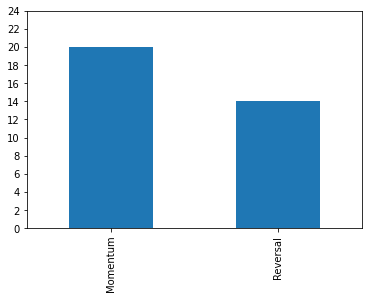

In [119]:
dfs[8]['Effect'].value_counts().plot(kind='bar',yticks=range(0,25,2))

In [485]:
dfs[0][:5]

Adj Close %Change  Cum Returns    Effect
Name Date                                                
AAPL 2010-04-30          -0.088597     0.911403  Reversal
     2010-08-31           0.337499     1.219001  Momentum
     2010-12-31           0.104601     1.346510  Momentum
     2011-04-30           0.195841     1.610212  Momentum
     2011-08-31           0.025080     1.650595  Momentum

In [489]:
aapl.date

name
AAPL   2010-02-01
AAPL   2010-03-01
AAPL   2010-04-01
AAPL   2010-05-01
AAPL   2010-06-01
          ...    
AAPL   2020-12-01
AAPL   2021-01-01
AAPL   2021-02-01
AAPL   2021-03-01
AAPL   2021-03-05
Name: date, Length: 135, dtype: datetime64[ns]

In [ ]:
new_df = pd.merge_asof(dfs[0].reset_index(),aapl,on='Date')
new_df['Name'] = 'AAPL'
new_df.set_index(['Name','Date'],inplace=True)
new_df = new_df[~new_df.index.duplicated(keep='first')]
new_df

In [483]:
import pandas_ta as ta

## a few from momentum and trend. whats the best possible params? 10 might be way too b
new_df.ta.cores = 7
new_df.ta.sma(length=8, append=True)
new_df.ta.rsi(append=True)
new_df.ta.cci(length=8, append=True)
new_df['return std'] = new_df['Cum Returns'].rolling(2).std()
new_df.ta.willr(length=k/2, append=True)
new_df.ta.roc(length=k/2,append=True)
new_df.ta.ema(append=True)
new_df.ta.pdist(append=True)
new_df.ta.variance(length=4,append=True)
new_df.ta.psar(append=True)
new_df = new_df.join(pd.get_dummies(new_df.Effect, prefix='Effect')) #one hot
new_df

NameError: name 'new_df' is not defined

In [ ]:
import seaborn as sns

corr = new_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="PuBuGn", vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
new_df

In [ ]:
# def K_ranking(ticker_df):
def K_ranking(start_time, end_time):
    '''given a time range, this reads in OHLC data of the s&p500 and converts it into usable features.'''
    

# Modeling:
Below we start to really look at feature engineering, not much here yet

In [ ]:
# pd.read_csv('constituent_performance_4_months.csv')

In [ ]:
# momentum/ model: given a huge dataset with daily/monthly data, we determine in an initial period J to find which tickers do the best/worst, 

## ---notes below---

# For the momentum analysis portion:
The way we plan to proceed for now is to give each stock in our index (sp500) equal weights, in a sense, then rank them by some criteria on how well they are performing. we will adopt the observe J and hold K strategy as detailed in the paper, in which there is an observatory period of J quarters/months/days and a holding period of K quarters/months/days (Ben: idk, j might be able to overlap with k, we can do a lot with how we implement it). In short, we classify in the J period whether a particular ticker would be best treated with a momentum or reversal strategy, or some other. The classification task here is thus presented.

momentum strategy: buy/give heavier weights over time to well performing stocks, as we assume they will continue to get better as per our understanding of momentum

reversal strategy: Amir proposed we short underperforming stocks. This strategy we adopt *might* actually be different from what the paper is proposing, which is to buy and hold underperforming stocks as we predict it to rebound (Ben: fact check me pls).

stocks in between: dont buy them, or leave them as they are...? feel free to share your own thoughts.

# For the modeling portion: 
a lot still left untouched, ill think a bit harder about it tmr ...
we want 3 models to do this kind of momentum analysis algorithmically vs manually, and pit it against a baseline of a simple buy and hold strategy. The parameters will come from a wealth of technical analysis (read: all the fancy hard to understand financial forecasting stuff) libraries already available (we probably wont be making most of them, beyond the simple stuff) but we do have a deadline to keep in mind.

momentum groups have positive trensds, high return rates, 

reversal groups are stocks taht are losing. 
dynamically managing the 500 tickers in s&p.

hwo do we predict who is going into momentum group at t+k, and how accurate can we be?
based on the pricing trends, who will be in reversal and who will be in momentum?
    a lot of room to work with
bactesting takes our predictions and our model trained to figure out how to weight the positions of the stocks, we would take that strategy and test it on historical data

we would have a lot to talk about in terms of a paper, how to improve, what not to notice
how it could be used in the real world market

do we want to create our own feature on which ticker is profitable, or 
- returns? predicting reurns over a certain period\\
- the momentum to reversal ratio for a particular 
- more categorical features interpreted from indicators
if we could answer these questions, how to implement above
predictions on who goes where, then we can find out which features can increase accuracy over time, then weights, risk parameter, where the algo tries to place the stocks momentum and reversal groups and then it meets the parameter that we feed
how do I predict, say, can we predict the possible return and then see, based on that,..
there are certain indicators 
moving averages, where they change is a trend reversal indicate where and when that happens
if we need more features

waht would be a good starting point for us to start on?
- creating features? familiarizing ourselgves with this notebook
- we bought here and held there\
- maybe correlation analysis? taking old data and shiftiing it around to create and make it as accurate as possible for one of those and then figuring out which one of these affect accuracy of who goes in what group.
tldr the sooner we play with the features bnetter 
who is in momentum who is in reversal based on certain criteria?
for momentum and reversal, we are predicting return, get rmse beneath 80, and then visualize how it places and then prefirmance. start iterating on that part. cumulative returns vs actual returns
creating better features?
tuning parameters to modify the suggestion you would give based on momentum group.
no effect is that it dont make it int
we have many variables to compare the two. lower profiitability and higher rate. if it kept your risk constrained and you still had a significant strategy



analyze at j, hold for k. 
evaluating when it hits the lowest...?




so we have stocks, are we predicting profitability? -its not a difficult question to ask. we are predicting 

shweta as a clasirifation problem, momentum nad reversal. 
if we went back to momentum and reversal?
- with these, can we predict return? pick a momentum or reversal group 
we label with momentum and reversal. say we have a collection, and a group at certain points. predict return? if you were to hold them for a time. use calculations for holding, having a certain period  and hold? for a certain amount. eg 2010 to 2015, we have all the return data, take the 

could we create a concrete quesiton
xgd regressor
> check out the moethodology portion